In [1]:
import pickle as pkl
from collections import defaultdict
import pandas as pd

output_path = None

def load_results(predictions_path):
    '''
    Return dictionary with distribution of predictions by accent
    '''
    with open(predictions_path, "rb") as f:
        eval_data = pkl.load(f)
    
    predictions_by_accent = defaultdict(lambda: defaultdict(int))
    for prediction, accent in zip(eval_data["preds"], eval_data["accents"]):
        predictions_by_accent[accent][prediction] += 1

    return predictions_by_accent




In [4]:
predictions_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid23/results/preds_edacc_gt10sec_ws2_v3.npy"

In [ ]:
import numpy as np
import os

def load_results(predictions_path):
    '''
    Return dictionary with distribution of predictions by accent
    '''
    eval_data = np.load(predictions_path, allow_pickle=True).item()
    
    predictions_by_accent = defaultdict(lambda: defaultdict(int))
    for prediction, accent in zip(eval_data["preds"], eval_data["accents"]):
        predictions_by_accent[accent][prediction] += 1

    return predictions_by_accent

In [19]:
ids[:10]

array(['EDACC-C01-000000001-0', 'EDACC-C01-000000001-1',
       'EDACC-C01-000000001-2', 'EDACC-C01-000000001-3',
       'EDACC-C01-000000001-4', 'EDACC-C01-000000003-0',
       'EDACC-C01-000000003-1', 'EDACC-C01-000000003-2',
       'EDACC-C01-000000003-3', 'EDACC-C01-000000003-4'], dtype='<U26')

In [76]:
import json
def get_lang2idx_map(dataset_dir):
    '''Get the mapping from language to index'''

    ### CHANGE THIS TO DATASET_DIR
    # langs = os.listdir(training_units_dir)

    if dataset_dir == "vl107":
        langs_dir = "/exp/jvillalba/corpora/voxlingua107"
    elif dataset_dir == "fleurs":
        langs_dir = "/export/common/data/corpora/fleurs/metadata"
    langs = sorted(os.listdir(langs_dir))
    lang2idx = {lang: idx for idx, lang in enumerate(langs)}
    idx2lang = {idx: lang for lang, idx in lang2idx.items()}
    # langs = ["ar", "hi", "en"]
    return lang2idx, idx2lang, langs


def get_matthews_lang2idx_map():
    path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/lang2idx.json"
    with open(path, "r") as f:
        idx2lang = json.load(f)
    lang2idx = {idx: lang for lang, idx in idx2lang.items()}
    langs = list(lang2idx.keys())
    return lang2idx, idx2lang, langs

def speaker2accent_map():
    with open("/exp/nbafna/data/edacc/edacc_v1.0/participant2accent.json", "r") as f:
        speaker2accent = json.load(f)
    # for p, a in speaker2accent.items():
        # if a == "us":
            # speaker2accent[p] = "american"
    return speaker2accent

In [100]:
import os
import numpy as np


lang2idx, idx2lang, langs = get_matthews_lang2idx_map()
speaker2accent = speaker2accent_map()

# # GEO
predictions_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid23/results/preds_edacc_gt10sec_ws2_v3.npy"
tgts_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid23/results/tgts_edacc_gt10sec_ws2_v3.npy"
spks_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid23/results/spks_edacc_gt10sec_ws2_v3.npy"
ids_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid23/results/ids_edacc_gt10sec_ws2_v3.npy"

# predictions_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid24/results/preds_edacc_gt10sec_ws10_v3.npy"
# tgts_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid24/results/tgts_edacc_gt10sec_ws10_v3.npy"
# spks_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid24/results/spks_edacc_gt10sec_ws10_v3.npy"
# ids_path = "/expscratch/mwiesner/scale23/scale2023/icefall/tools/icefall/egs/radio/language_id/exp_lid24/results/ids_edacc_gt10sec_ws10_v3.npy"

preds = np.load(predictions_path, allow_pickle=True)
tgts = np.load(tgts_path, allow_pickle=True)
spks = np.load(spks_path, allow_pickle=True)
ids = np.load(ids_path, allow_pickle=True)


In [101]:
predictions_by_accent = defaultdict(lambda: defaultdict(int))
for pred, tgt, spk in zip(preds, tgts, spks):
    accent = speaker2accent[spk]
    pred_lang = idx2lang[str(pred)]
    predictions_by_accent[accent][pred_lang.split("_")[0]] += 1

In [102]:
def print_top_3_confusions(preds_by_accent):
    # Normalize the predictions
    for accent, predictions in preds_by_accent.items():
        total = sum(predictions.values()) - predictions["en"]
        for prediction, count in predictions.items():
            preds_by_accent[accent][prediction] = round((count/total)*100, 1) if total > 0 else 0

    # Print out the top 3 confusions for each accent
    for accent, predictions in preds_by_accent.items():
        print(f"Top 3 confusions for {accent}:")
        for prediction, count in sorted([x for x in predictions.items() if x[0] != "en"], key=lambda x: x[1], reverse=True)[:3]:
            print(f"{prediction}: {count}")
        print()

def get_top_3_confusions(preds_by_accent):
    # Normalize the predictions
    for accent, predictions in preds_by_accent.items():
        total = sum(predictions.values()) - predictions["en"]
        for prediction, count in predictions.items():
            preds_by_accent[accent][prediction] = round((count/total)*100, 1) if total > 0 else 0

    top_confusions = defaultdict(lambda: defaultdict(float))
    for accent, predictions in preds_by_accent.items():
        for prediction, count in sorted([x for x in predictions.items() if x[0] != "en"], key=lambda x: x[1], reverse=True)[:3]:
            top_confusions[accent][prediction] = count

    return top_confusions

In [103]:
top_confusions = get_top_3_confusions(predictions_by_accent)
mms_confusions = {accent: [(k, v) for k, v in top_confusions[accent].items()] for accent in top_confusions}

In [104]:
mms_confusions

{'italian': [('cy', 25.5), ('ga', 10.4), ('mt', 4.7)],
 'lithuanian': [('ga', 20.1), ('cy', 15.9), ('sv', 9.2)],
 'bulgarian': [('cy', 24.0), ('sv', 7.6), ('bg', 7.4)],
 'korean': [('cy', 48.1), ('ga', 14.8), ('af', 3.7)],
 'uk': [('cy', 53.3), ('ga', 10.4), ('es', 4.7)],
 'dutch': [('nl', 30.7), ('ga', 21.6), ('cy', 13.6)],
 'chinese': [('cy', 31.2), ('ga', 12.2), ('es', 6.7)],
 'indian': [('cy', 16.7), ('ur', 7.4), ('ga', 6.4)],
 'sinhalese': [('cy', 25.7), ('sd', 6.4), ('ga', 6.4)],
 'scottish': [('ga', 39.1), ('cy', 37.1), ('da', 5.0)],
 'japanese': [('cy', 30.7), ('cmn', 8.9), ('ko', 7.9)],
 'romanian': [('cy', 21.2), ('ro', 5.3), ('es', 4.6)],
 'pakistani': [('ga', 26.6), ('sd', 11.0), ('cy', 7.2)],
 'polish': [('cy', 28.9), ('ga', 22.3), ('sv', 5.7)],
 'ecuadorian': [('cy', 27.6), ('ga', 13.8), ('es', 10.3)],
 'american': [('cy', 57.7), ('es', 7.7), ('ga', 7.7)],
 'spanish': [('cy', 29.3), ('ga', 11.1), ('ca', 9.3)],
 'catalan': [('cy', 24.8), ('ca', 24.3), ('ga', 6.8)],
 'shona

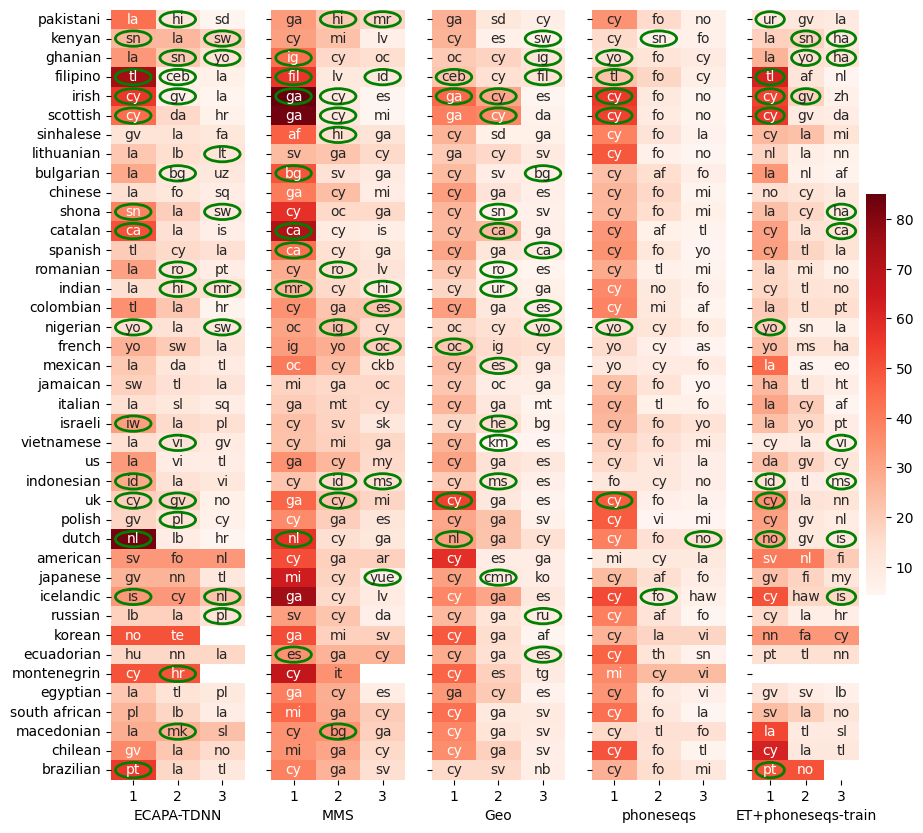

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

confusions_ET = {'scottish': [('cy', 43.8), ('da', 16.3), ('hr', 5.9)],
 'sinhalese': [('gv', 13.1), ('la', 13.1), ('fa', 11.5)],
 'lithuanian': [('la', 21.3), ('lb', 14.8), ('lt', 12.4)],
 'bulgarian': [('la', 29.1), ('bg', 10.8), ('uz', 10.3)],
 'chinese': [('la', 14.4), ('fo', 11.5), ('sq', 8.7)],
 'shona': [('sn', 38.9), ('la', 19.4), ('sw', 11.1)],
 'catalan': [('ca', 50.1), ('la', 13.9), ('is', 7.5)],
 'spanish': [('tl', 19.9), ('cy', 16.0), ('la', 13.9)],
 'romanian': [('la', 31.0), ('ro', 12.6), ('pt', 8.3)],
 'indian': [('la', 14.4), ('hi', 14.4), ('mr', 14.4)],
 'colombian': [('tl', 35.1), ('la', 21.6), ('hr', 5.4)],
 'nigerian': [('yo', 14.6), ('la', 13.7), ('sw', 10.9)],
 'french': [('yo', 27.3), ('sw', 20.2), ('la', 12.1)],
 'mexican': [('la', 20.9), ('da', 11.6), ('tl', 9.3)],
 'pakistani': [('la', 43.3), ('hi', 12.0), ('sd', 4.3)],
 'kenyan': [('sn', 26.0), ('la', 25.2), ('sw', 18.6)],
 'ghanian': [('la', 33.2), ('sn', 21.0), ('yo', 13.2)],
 'filipino': [('tl', 75.0), ('ceb', 7.1), ('la', 7.1)],
 'irish': [('cy', 55.7), ('gv', 7.2), ('la', 5.2)],
 'jamaican': [('sw', 18.8), ('tl', 13.9), ('la', 12.5)],
 'italian': [('la', 14.1), ('sl', 11.4), ('sq', 8.6)],
 'israeli': [('iw', 31.5), ('la', 15.4), ('pl', 14.1)],
 'vietnamese': [('la', 14.4), ('vi', 12.6), ('gv', 9.3)],
 'us': [('la', 32.4), ('vi', 8.1), ('tl', 8.1)],
 'indonesian': [('id', 29.0), ('la', 13.5), ('vi', 11.5)],
 'uk': [('cy', 19.4), ('gv', 17.5), ('no', 7.1)],
 'polish': [('gv', 17.4), ('pl', 13.0), ('cy', 6.5)],
 'dutch': [('nl', 82.6), ('lb', 8.7), ('hr', 4.3)],
 'american': [('sv', 33.3), ('fo', 33.3), ('nl', 33.3)],
 'japanese': [('gv', 26.3), ('nn', 26.3), ('tl', 10.5)],
 'icelandic': [('is', 33.3), ('cy', 33.3), ('nl', 22.2)],
 'russian': [('lb', 18.8), ('la', 18.8), ('pl', 12.5)],
 'korean': [('no', 50.0), ('te', 50.0)],
 'ecuadorian': [('hu', 16.7), ('nn', 16.7), ('la', 16.7)],
 'montenegrin': [('cy', 50.0), ('hr', 50.0)],
 'egyptian': [('la', 21.2), ('tl', 13.1), ('pl', 10.1)],
 'south african': [('pl', 25.9), ('lb', 17.2), ('la', 8.6)],
 'macedonian': [('la', 27.7), ('mk', 27.7), ('sl', 23.4)],
 'chilean': [('gv', 36.8), ('la', 21.1), ('no', 15.8)],
 'brazilian': [('pt', 55.6), ('la', 16.7), ('tl', 11.1)]}


confusions_PS = {'italian': [('cy', 27.1), ('tl', 7.9), ('fo', 7.5)],
 'lithuanian': [('cy', 49.1), ('fo', 7.4), ('no', 5.7)],
 'bulgarian': [('cy', 24.1), ('af', 15.9), ('fo', 8.7)],
 'korean': [('cy', 27.3), ('la', 18.2), ('vi', 18.2)],
 'uk': [('cy', 48.6), ('fo', 8.5), ('la', 6.8)],
 'chinese': [('cy', 26.6), ('fo', 17.4), ('mi', 6.4)],
 'ecuadorian': [('cy', 46.7), ('th', 13.3), ('sn', 6.7)],
 'romanian': [('cy', 29.2), ('tl', 7.4), ('mi', 6.4)],
 'indian': [('cy', 37.5), ('no', 11.0), ('fo', 7.7)],
 'pakistani': [('cy', 35.0), ('fo', 16.6), ('no', 7.6)],
 'polish': [('cy', 48.2), ('vi', 5.9), ('mi', 5.9)],
 'scottish': [('cy', 54.0), ('fo', 10.3), ('no', 6.3)],
 'sinhalese': [('cy', 39.0), ('fo', 13.6), ('la', 6.8)],
 'dutch': [('cy', 40.0), ('fo', 15.0), ('no', 15.0)],
 'american': [('mi', 11.1), ('cy', 11.1), ('la', 11.1)],
 'japanese': [('cy', 25.0), ('af', 15.6), ('fo', 9.4)],
 'icelandic': [('cy', 52.0), ('fo', 12.0), ('haw', 8.0)],
 'french': [('yo', 16.5), ('cy', 8.3), ('as', 5.8)],
 'shona': [('cy', 26.3), ('fo', 15.8), ('mi', 7.9)],
 'catalan': [('cy', 33.7), ('af', 7.9), ('tl', 6.5)],
 'spanish': [('cy', 34.8), ('fo', 12.3), ('yo', 5.8)],
 'russian': [('cy', 39.7), ('af', 13.7), ('fo', 5.5)],
 'colombian': [('cy', 38.8), ('mi', 12.2), ('af', 6.1)],
 'mexican': [('yo', 12.2), ('cy', 10.2), ('fo', 10.2)],
 'filipino': [('tl', 23.2), ('fo', 17.9), ('cy', 8.9)],
 'tagalog': [('cy', 83.3), ('mt', 16.7)],
 'nigerian': [('yo', 14.8), ('cy', 13.4), ('fo', 9.8)],
 'montenegrin': [('mi', 37.5), ('cy', 25.0), ('vi', 25.0)],
 'kenyan': [('cy', 16.4), ('sn', 7.4), ('fo', 7.3)],
 'ghanian': [('yo', 14.8), ('fo', 13.4), ('cy', 10.5)],
 'indonesian': [('fo', 11.6), ('cy', 11.6), ('no', 8.8)],
 'egyptian': [('cy', 34.4), ('fo', 10.9), ('vi', 8.3)],
 'south african': [('cy', 43.8), ('fo', 11.6), ('la', 5.4)],
 'macedonian': [('cy', 17.0), ('tl', 14.9), ('fo', 14.9)],
 'irish': [('cy', 55.9), ('fo', 11.3), ('no', 5.6)],
 'jamaican': [('cy', 23.7), ('fo', 14.2), ('yo', 5.9)],
 'chilean': [('cy', 50.0), ('fo', 14.5), ('tl', 6.5)],
 'brazilian': [('cy', 28.0), ('fo', 16.0), ('mi', 12.0)],
 'israeli': [('cy', 26.0), ('fo', 17.1), ('yo', 14.4)],
 'vietnamese': [('cy', 19.5), ('fo', 15.0), ('mi', 10.9)],
 'us': [('cy', 17.1), ('vi', 11.4), ('la', 8.6)]}


confusions_geo = {'italian': [('cy', 25.5), ('ga', 10.4), ('mt', 4.7)],
 'lithuanian': [('ga', 20.1), ('cy', 15.9), ('sv', 9.2)],
 'bulgarian': [('cy', 24.0), ('sv', 7.6), ('bg', 7.4)],
 'korean': [('cy', 48.1), ('ga', 14.8), ('af', 3.7)],
 'uk': [('cy', 53.3), ('ga', 10.4), ('es', 4.7)],
 'dutch': [('nl', 30.7), ('ga', 21.6), ('cy', 13.6)],
 'chinese': [('cy', 31.2), ('ga', 12.2), ('es', 6.7)],
 'indian': [('cy', 16.7), ('ur', 7.4), ('ga', 6.4)],
 'sinhalese': [('cy', 25.7), ('sd', 6.4), ('ga', 6.4)],
 'scottish': [('ga', 39.1), ('cy', 37.1), ('da', 5.0)],
 'japanese': [('cy', 30.7), ('cmn', 8.9), ('ko', 7.9)],
 'romanian': [('cy', 21.2), ('ro', 5.3), ('es', 4.6)],
 'pakistani': [('ga', 26.6), ('sd', 11.0), ('cy', 7.2)],
 'polish': [('cy', 28.9), ('ga', 22.3), ('sv', 5.7)],
 'ecuadorian': [('cy', 27.6), ('ga', 13.8), ('es', 10.3)],
 'american': [('cy', 57.7), ('es', 7.7), ('ga', 7.7)],
 'spanish': [('cy', 29.3), ('ga', 11.1), ('ca', 9.3)],
 'catalan': [('cy', 24.8), ('ca', 24.3), ('ga', 6.8)],
 'shona': [('cy', 25.4), ('sn', 6.0), ('sv', 6.0)],
 'french': [('oc', 20.4), ('ig', 15.0), ('cy', 14.3)],
 'russian': [('cy', 24.5), ('ga', 11.8), ('ru', 8.2)],
 'icelandic': [('cy', 37.2), ('ga', 29.5), ('es', 10.3)],
 'nigerian': [('oc', 16.7), ('cy', 13.8), ('yo', 11.3)],
 'filipino': [('ceb', 21.2), ('cy', 13.6), ('fil', 12.9)],
 'tagalog': [('cy', 50.0), ('es', 30.0), ('ceb', 10.0)],
 'colombian': [('cy', 31.1), ('ga', 9.9), ('es', 7.9)],
 'mexican': [('cy', 23.4), ('es', 13.3), ('ga', 9.4)],
 'kenyan': [('cy', 25.8), ('es', 5.7), ('sw', 5.4)],
 'montenegrin': [('cy', 45.5), ('es', 18.2), ('tg', 9.1)],
 'ghanian': [('oc', 20.2), ('cy', 17.1), ('ig', 11.6)],
 'indonesian': [('cy', 19.7), ('ms', 11.1), ('es', 6.7)],
 'egyptian': [('ga', 33.1), ('cy', 20.2), ('es', 5.1)],
 'south african': [('cy', 42.9), ('ga', 9.5), ('sv', 9.1)],
 'macedonian': [('cy', 37.3), ('ga', 11.9), ('sv', 8.5)],
 'irish': [('ga', 44.9), ('cy', 29.2), ('es', 3.7)],
 'jamaican': [('cy', 21.1), ('oc', 8.1), ('ga', 7.4)],
 'brazilian': [('cy', 15.7), ('sv', 15.7), ('nb', 7.4)],
 'vietnamese': [('cy', 25.8), ('km', 4.2), ('es', 4.2)],
 'israeli': [('cy', 16.5), ('he', 14.2), ('bg', 6.1)],
 'chilean': [('cy', 35.5), ('ga', 18.3), ('sv', 7.1)],
 'us': [('cy', 29.8), ('ga', 13.2), ('es', 9.9)]}

confusions_mms = {'italian': [('ga', 17.7), ('mt', 15.3), ('cy', 13.8)],
 'lithuanian': [('sv', 22.5), ('ga', 20.1), ('cy', 14.3)],
 'bulgarian': [('bg', 48.1), ('sv', 11.7), ('ga', 7.8)],
 'korean': [('ga', 50.0), ('mi', 16.7), ('sv', 16.7)],
 'uk': [('ga', 44.4), ('cy', 20.4), ('mi', 15.6)],
 'chinese': [('ga', 39.1), ('cy', 21.9), ('mi', 6.2)],
 'ecuadorian': [('es', 33.3), ('ga', 25.0), ('cy', 25.0)],
 'romanian': [('cy', 26.6), ('ro', 12.8), ('lv', 10.5)],
 'indian': [('mr', 24.5), ('cy', 14.2), ('hi', 8.9)],
 'pakistani': [('ga', 30.6), ('hi', 19.0), ('mr', 15.0)],
 'polish': [('cy', 35.0), ('ga', 17.5), ('es', 10.0)],
 'scottish': [('ga', 83.1), ('cy', 8.3), ('mi', 2.1)],
 'sinhalese': [('af', 45.7), ('hi', 13.0), ('ga', 10.9)],
 'dutch': [('nl', 56.3), ('cy', 12.5), ('ga', 9.4)],
 'american': [('cy', 50.0), ('ga', 16.7), ('ar', 16.7)],
 'japanese': [('mi', 63.1), ('cy', 15.8), ('yue', 5.3)],
 'icelandic': [('ga', 75.0), ('cy', 14.3), ('lv', 7.1)],
 'french': [('ig', 30.5), ('yo', 26.2), ('oc', 17.5)],
 'shona': [('cy', 57.1), ('oc', 14.3), ('ga', 14.3)],
 'catalan': [('ca', 71.4), ('cy', 7.1), ('is', 5.7)],
 'spanish': [('ca', 42.1), ('cy', 12.1), ('ga', 9.4)],
 'russian': [('sv', 30.0), ('cy', 20.0), ('da', 5.0)],
 'colombian': [('cy', 33.3), ('ga', 20.0), ('es', 20.0)],
 'filipino': [('fil', 55.2), ('lv', 7.9), ('id', 7.9)],
 'tagalog': [('cy', 50.0), ('ga', 25.0), ('ig', 25.0)],
 'mexican': [('oc', 38.8), ('cy', 22.2), ('ckb', 11.1)],
 'nigerian': [('oc', 28.9), ('ig', 21.7), ('cy', 13.9)],
 'montenegrin': [('cy', 66.7), ('it', 33.3)],
 'kenyan': [('cy', 29.8), ('mi', 21.3), ('lv', 5.1)],
 'ghanian': [('ig', 42.0), ('cy', 14.5), ('oc', 12.9)],
 'indonesian': [('cy', 20.0), ('id', 13.8), ('ms', 12.3)],
 'egyptian': [('ga', 37.8), ('cy', 26.3), ('es', 6.6)],
 'south african': [('mi', 43.6), ('ga', 26.9), ('cy', 17.9)],
 'macedonian': [('cy', 33.3), ('bg', 33.3), ('ga', 16.7)],
 'irish': [('ga', 84.8), ('cy', 8.0), ('es', 2.0)],
 'jamaican': [('mi', 16.2), ('ga', 14.5), ('oc', 14.5)],
 'brazilian': [('cy', 37.5), ('ga', 25.0), ('sv', 12.5)],
 'chilean': [('mi', 33.2), ('ga', 28.5), ('cy', 14.3)],
 'israeli': [('cy', 21.4), ('sv', 16.1), ('sk', 8.9)],
 'vietnamese': [('cy', 21.0), ('mi', 16.8), ('ga', 14.8)],
 'us': [('ga', 33.3), ('cy', 23.8), ('my', 14.3)]}


confusions_etps = {'scottish': [('cy', 55.6), ('gv', 9.4), ('da', 8.7)],
 'sinhalese': [('cy', 24.7), ('la', 23.2), ('mi', 12.3)],
 'lithuanian': [('nl', 18.0), ('la', 8.0), ('nn', 6.0)],
 'bulgarian': [('la', 33.5), ('nl', 6.7), ('af', 5.4)],
 'chinese': [('no', 14.6), ('cy', 13.1), ('la', 10.2)],
 'shona': [('la', 23.3), ('cy', 16.7), ('ha', 10.0)],
 'catalan': [('cy', 31.0), ('la', 13.4), ('ca', 13.2)],
 'spanish': [('cy', 31.1), ('tl', 17.3), ('la', 13.1)],
 'romanian': [('la', 16.8), ('mi', 11.7), ('no', 7.1)],
 'indian': [('cy', 16.9), ('tl', 13.0), ('no', 12.4)],
 'colombian': [('la', 20.0), ('tl', 15.0), ('pt', 15.0)],
 'nigerian': [('yo', 19.3), ('sn', 6.8), ('la', 6.8)],
 'french': [('yo', 24.1), ('ms', 13.0), ('ha', 13.0)],
 'mexican': [('la', 44.3), ('as', 4.7), ('eo', 4.7)],
 'pakistani': [('ur', 10.6), ('gv', 10.6), ('la', 9.8)],
 'kenyan': [('la', 18.5), ('sn', 17.7), ('ha', 9.6)],
 'ghanian': [('la', 26.1), ('yo', 14.3), ('ha', 12.3)],
 'filipino': [('tl', 61.8), ('af', 11.9), ('nl', 4.8)],
 'tagalog': [('cy', 100.0)],
 'irish': [('cy', 53.3), ('gv', 17.8), ('zh', 6.2)],
 'jamaican': [('ha', 25.1), ('tl', 10.8), ('ht', 7.5)],
 'italian': [('la', 29.7), ('cy', 20.0), ('af', 4.3)],
 'israeli': [('la', 23.3), ('yo', 16.9), ('pt', 8.5)],
 'vietnamese': [('cy', 9.9), ('la', 9.1), ('vi', 7.9)],
 'us': [('da', 23.5), ('gv', 17.6), ('cy', 11.8)],
 'indonesian': [('id', 13.1), ('tl', 8.3), ('ms', 7.8)],
 'uk': [('cy', 34.9), ('la', 12.8), ('nn', 12.3)],
 'polish': [('cy', 31.2), ('gv', 11.1), ('nl', 8.9)],
 'dutch': [('no', 30.0), ('gv', 10.0), ('is', 10.0)],
 'american': [('sv', 40.0), ('nl', 40.0), ('fi', 20.0)],
 'japanese': [('gv', 23.5), ('fi', 17.6), ('my', 11.8)],
 'icelandic': [('cy', 50.0), ('haw', 16.7), ('is', 16.7)],
 'russian': [('cy', 16.0), ('la', 8.0), ('hr', 8.0)],
 'korean': [('nn', 33.3), ('fa', 33.3), ('cy', 33.3)],
 'ecuadorian': [('pt', 14.3), ('tl', 14.3), ('nn', 14.3)],
 'egyptian': [('gv', 12.8), ('sv', 8.5), ('lb', 6.4)],
 'south african': [('sv', 23.8), ('la', 19.0), ('no', 11.9)],
 'macedonian': [('la', 52.3), ('tl', 9.5), ('sl', 9.5)],
 'chilean': [('cy', 62.2), ('la', 10.3), ('tl', 10.3)],
 'brazilian': [('pt', 50.0), ('no', 50.0)],
 'montenegrin': []}

accent_language_map = {
    "pakistani": ["hi", "ur", "mr", "sd"],
    "kenyan": ["sw", "sn", "ha"],
    "ghanian": ["yo", "sn", "ig", "ha"],
    "filipino": ["tl", "ceb", "fil", "id"],
    "irish": ["cy", "gv", "ga"],
    "scottish": ["cy", "gd", ],
    "sinhalese": ["hi"],
    "lithuanian": ["lt", "lv"],
    "bulgarian": ["bg", "mk"],
    "chinese": ["zh", "yue"],
    "shona": ["sn", "sw", "ha"],
    "catalan": ["ca", "es"],
    "spanish": ["es", "ca"],
    "romanian": ["ro"],
    "indian": ["hi", "mr", "ta", "te", "ur"],
    "colombian": ["es", "qu"],
    "nigerian": ["yo", "sw", "ig"],     
    "french": ["fr", "oc"],
    "mexican": ["es", "nah"],
    "jamaican": ["en", "jam"],
    "italian": ["it", "sc"],
    "israeli": ["iw", "ar", "he"],
    "vietnamese": ["vi", "hmn", "km"],
    "us": ["en"],
    "indonesian": ["id", "jv", "ms"],
    "uk": ["gv", "cy"],
    "polish": ["pl", "cs"],
    "dutch": ["nl", "no", "is"],
    "american": ["en"],
    "japanese": ["ja", "ryu", "cmn", "yue"],
    "icelandic": ["is", "nl", "fo"],
    "russian": ["ru", "pl"],
    "korean": ["ko", "zh"],
    "ecuadorian": ["es", "qu"],
    "montenegrin": ["hr"],
    "egyptian": ["ar", "cop"],
    "south african": ["af", "zu"],
    "macedonian": ["mk", "bg"],
    "chilean": ["es", "map"],
    "brazilian": ["pt", "tup"]
}



# Your data (confusions_ET, confusions_PS, accent_language_map) remains the same

accent_groups = [list(accent_language_map.keys())[i:i+40] for i in range(0, len(accent_language_map), 40)]
accents = accent_language_map.keys()

# Create subplots with 2 columns (one for ET and one for PS)
fig, axes = plt.subplots(1, 5, figsize=(10, 10), sharey=False)

# Put space between subplots
# plt.subplots_adjust(wspace=0.5)
# Put space between subplot 2 and 3
plt.subplots_adjust(wspace=0.2)
# Make subplot 0 and 2 wider

# axes[0].set_position([0.1, 0.1, 0.4, 0.8])
# axes[2].set_position([0.5, 0.1, 0.4, 0.8])

# Put thick black line between subplot 2 and 3

# axes[2].vlines(x=axes[1].get_xlim()[0] - 3, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1], color='black', linewidth=2)
# axes[1].plot([axes[1].get_xlim()[1], axes[1].get_xlim()[1]], [axes[1].get_ylim()[0], axes[1].get_ylim()[1]], color='black', linewidth=2)



cmap = sns.color_palette("Reds", as_cmap=True)

for idx, accents in enumerate(accent_groups):

    # print("idx", idx)
    labels_et = []
    values_et = []
    row_labels_et = []

    labels_ps = []
    values_ps = []
    row_labels_ps = []

    labels_geo = []
    values_geo = []
    row_labels_geo = []

    labels_mms = []
    values_mms = []
    row_labels_mms = []

    labels_etps = []
    values_etps = []
    row_labels_etps = []

    for accent in accents:
        # For ET
        labels_et.append([conf[0] for conf in confusions_ET[accent]])
        values_et.append([conf[1] for conf in confusions_ET[accent]])
        row_labels_et.append(f"{accent}")

        # For PS
        labels_ps.append([conf[0] for conf in confusions_PS[accent]])
        values_ps.append([conf[1] for conf in confusions_PS[accent]])
        row_labels_ps.append(f"{accent}")

        # For Geo
        labels_geo.append([conf[0] for conf in confusions_geo[accent]])
        values_geo.append([conf[1] for conf in confusions_geo[accent]])
        row_labels_geo.append(f"{accent}")

        # For MMS
        labels_mms.append([conf[0] for conf in confusions_mms[accent]])
        values_mms.append([conf[1] for conf in confusions_mms[accent]])
        row_labels_mms.append(f"{accent}")

        # For ETPS
        labels_etps.append([conf[0] for conf in confusions_etps[accent]])
        values_etps.append([conf[1] for conf in confusions_etps[accent]])
        row_labels_etps.append(f"{accent}")



    # DataFrames for ET and PS
    df_et = pd.DataFrame(values_et, columns=["1", "2", "3"], index=row_labels_et)
    labels_df_et = pd.DataFrame(labels_et, columns=["1", "2", "3"], index=row_labels_et)

    df_ps = pd.DataFrame(values_ps, columns=["1", "2", "3"])
    labels_df_ps = pd.DataFrame(labels_ps, columns=["1", "2", "3"])

    df_geo = pd.DataFrame(values_geo, columns=["1", "2", "3"])
    labels_df_geo = pd.DataFrame(labels_geo, columns=["1", "2", "3"])

    df_mms = pd.DataFrame(values_mms, columns=["1", "2", "3"])
    labels_df_mms = pd.DataFrame(labels_mms, columns=["1", "2", "3"])

    df_etps = pd.DataFrame(values_etps, columns=["1", "2", "3"])
    labels_df_etps = pd.DataFrame(labels_etps, columns=["1", "2", "3"])


    # ET heatmap (left column)
    ax_et = axes[0]
    cbar = False  # No color bar for ET
    sns.heatmap(df_et, vmax = 85, annot=labels_df_et, fmt="", cmap=cmap, ax=ax_et, cbar=cbar)
    ax_et.set_xlabel(f"ECAPA-TDNN")
    
    
    # Geo heatmap (right column)
    ax_geo = axes[2]
    cbar = False  # No color bar for Geo
    sns.heatmap(df_geo, vmax = 85, annot=labels_df_geo, fmt="", cmap=cmap, ax=ax_geo, cbar=cbar)
    ax_geo.set_xlabel(f"Geo")

    # MMS heatmap (right column)
    ax_mms = axes[1]
    cbar = False  # No color bar for MMS
    sns.heatmap(df_mms, vmax = 85, annot=labels_df_mms, fmt="", cmap=cmap, ax=ax_mms, cbar=cbar)
    ax_mms.set_xlabel(f"MMS")

    # PS heatmap (right column)
    ax_ps = axes[3]
    cbar = False  # Only show color bar for the rightmost subfigure
    sns.heatmap(df_ps, vmax = 85, annot=labels_df_ps, fmt="", cmap=cmap, ax=ax_ps, cbar=cbar, cbar_kws={'label': '% of total error'})
    ax_ps.set_xlabel(f"phoneseqs")

    # ETPS heatmap (right column)
    ax_etps = axes[4]
    cbar = True  # No color bar for ETPS
    sns.heatmap(df_etps, vmax = 85, annot=labels_df_etps, fmt="", cmap=cmap, ax=ax_etps, cbar=cbar)
    ax_etps.set_xlabel(f"ET+phoneseqs-train")


    # Highlight accent-related languages and add thick black lines for both ET and PS
    for i, accent in enumerate(row_labels_et):
        base_accent = accent  # Remove "ET" or "PS" part
        for j in range(3):
            if labels_df_et.iloc[i, j] in accent_language_map[base_accent]:
                ax_et.add_patch(plt.Circle((j+0.5, i+0.5), radius=0.4, fill=False, edgecolor='green', lw=2))

        # if i % 2 == 1:
        #     x_min, x_max = ax_et.get_xlim()
        #     ax_et.hlines(i + 1, x_min-10, x_max, colors='black', linewidth=2)  # Thick black line for ET

        # Repeat for PS (right column)
        for j in range(3):
            if labels_df_ps.iloc[i, j] in accent_language_map[base_accent]:
                ax_ps.add_patch(plt.Circle((j+0.5, i+0.5), radius=0.4, fill=False, edgecolor='green', lw=2))

        
        for j in range(3):
            if labels_df_geo.iloc[i, j] in accent_language_map[base_accent]:
                ax_geo.add_patch(plt.Circle((j+0.5, i+0.5), radius=0.4, fill=False, edgecolor='green', lw=2))

        for j in range(3):
            if labels_df_mms.iloc[i, j] in accent_language_map[base_accent]:
                ax_mms.add_patch(plt.Circle((j+0.5, i+0.5), radius=0.4, fill=False, edgecolor='green', lw=2))

        for j in range(3):
            if labels_df_etps.iloc[i, j] in accent_language_map[base_accent]:
                ax_etps.add_patch(plt.Circle((j+0.5, i+0.5), radius=0.4, fill=False, edgecolor='green', lw=2))

        # if i % 2 == 1:
        #     x_min, x_max = ax_ps.get_xlim()
        #     ax_ps.hlines(i + 1, x_min-10, x_max, colors='black', linewidth=2)  # Thick black line for PS

    # Set the labels for the yticks, which show for each subplot
    ax_et.set_yticks(np.arange(len(row_labels_et)) + 0.5, labels=row_labels_et)
    # Set empty yticks for PS
    ax_ps.set_yticks(np.arange(len(row_labels_ps)) + 0.5, labels=["" for _ in range(len(row_labels_ps))])

    ax_geo.set_yticks(np.arange(len(row_labels_geo)) + 0.5, labels=["" for _ in range(len(row_labels_geo))])
    ax_mms.set_yticks(np.arange(len(row_labels_mms)) + 0.5, labels=["" for _ in range(len(row_labels_mms))])

    ax_etps.set_yticks(np.arange(len(row_labels_etps)) + 0.5, labels=["" for _ in range(len(row_labels_etps))])

# Set the common y-label for all subplots
# axes[0, 0].set_ylabel("Accents")
# axes[0, 1].set_ylabel("Accents")

plt.savefig("accent_confusions.pdf", bbox_inches='tight')
